# ORIE 5255 Project Neural Network Part

In [1]:
import pandas as pd
import yfinance as yf # Yahoo Finance API to extract stock price data
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (10,10)

from datetime import datetime, timedelta
import torch # for neural network
import random

In [2]:
# extract stock price of the top 10 holdings (with available data from Yahoo Finance) in the IHE ETF (iShares US 
# Pharmaceuticals ETF: https://www.ishares.com/us/products/239519/ishares-us-pharmaceuticals-etf)
# in-sample period from 01/01/2018 to 01/01/2020
# out-of-sample period from 01/01/2020 to "today"
start = pd.to_datetime('2018, 1, 1')
end = pd.to_datetime("today")
tickers = ['BMY', 'CTLT', 'JAZZ', 'JNJ', 'LLY', 'MRK', 'PFE', 'PRGO', 'VTRS', 'ZTS']
df = yf.download(tickers, start=start, end=end)
adj_prices = df['Adj Close']
adj_prices

[*********************100%***********************]  10 of 10 completed


,BMY,CTLT,JAZZ,JNJ,LLY,MRK,PFE,PRGO,VTRS,ZTS
Date,,,,,,,,,,
2018-01-02,54.273048,42.040001,137.399994,126.012634,78.263412,47.838726,30.019209,84.361145,42.485291,70.102844
2018-01-03,54.317303,42.349998,138.929993,127.216362,78.688560,47.770653,30.241644,84.125999,42.514858,70.425194
2018-01-04,55.021214,41.779999,136.740005,127.207352,79.039749,48.544987,30.307545,85.668564,43.667900,70.845184
2018-01-05,55.145962,41.660000,135.589996,128.257233,80.010208,48.493935,30.365210,85.762611,43.894569,71.655930
2018-01-08,55.163780,41.500000,136.529999,128.420090,79.603546,48.213120,30.027451,84.774986,43.914280,72.515495
...,...,...,...,...,...,...,...,...,...,...
2021-10-25,57.810001,130.889999,142.679993,164.080002,245.050003,81.660004,43.150002,44.930000,13.800000,211.267685
2021-10-26,58.240002,133.509995,137.369995,165.750000,248.440002,82.250000,43.560001,44.400002,13.480000,210.268875
2021-10-27,56.490002,133.020004,133.960007,163.740005,250.169998,81.540001,42.970001,44.619999,13.100000,209.330002


In [3]:
# construct the input X matrix
# average adjusted closing price rolling every 10-day (train set & test set)
MA_10d = adj_prices.rolling(10).mean().dropna()
MA_10d_train = MA_10d.loc[:pd.to_datetime('12-30-2019')]
MA_10d_test = MA_10d.loc[pd.to_datetime('01-01-2020'):(pd.to_datetime('today') - timedelta(2))]
MA_10d_train

,BMY,CTLT,JAZZ,JNJ,LLY,MRK,PFE,PRGO,VTRS,ZTS
Date,,,,,,,,,,
2018-01-16,54.930360,42.186000,141.885999,129.375875,79.378031,48.969594,30.137016,85.319596,44.208945,72.138447
2018-01-17,55.014087,42.287000,143.117000,130.077306,79.519437,49.463978,30.197979,85.499247,44.570627,72.626833
2018-01-18,55.091607,42.293999,144.149001,130.652931,79.582284,49.888587,30.221044,85.710878,44.902743,73.052264
2018-01-19,55.138832,42.409999,145.345000,131.269278,79.579513,50.248525,30.233401,85.786124,45.141236,73.464069
2018-01-22,55.262685,42.614000,147.028000,131.851233,79.475074,50.611016,30.239167,85.998695,45.446744,73.878941
...,...,...,...,...,...,...,...,...,...,...
2019-12-23,59.482139,53.543000,150.113000,136.690187,121.759119,80.743124,34.336198,52.362570,18.936555,125.531178
2019-12-24,59.582751,53.836000,150.480000,137.257947,122.772527,81.008598,34.407875,52.344196,19.048903,126.533880
2019-12-26,59.728497,54.240001,150.931001,137.721518,123.776247,81.275801,34.510525,52.215579,19.124787,127.470325


In [4]:
# maximun stock price minus minimum stock price rolling every 10-day (train set & test set)
max_minus_min = adj_prices.rolling(10).max().dropna() - adj_prices.rolling(10).min().dropna()
max_minus_min_train = max_minus_min.loc[:pd.to_datetime('12-30-2019')]
max_minus_min_test = max_minus_min.loc[pd.to_datetime('01-01-2020'):(pd.to_datetime('today') - timedelta(2))]
max_minus_min_train

,BMY,CTLT,JAZZ,JNJ,LLY,MRK,PFE,PRGO,VTRS,ZTS
Date,,,,,,,,,,
2018-01-16,2.575081,1.500000,14.600006,6.905685,2.125710,5.045940,0.370714,2.398483,3.735081,3.682449
2018-01-17,2.575081,1.549999,14.600006,5.819595,1.700562,5.045940,0.634338,2.398483,3.705513,4.561516
2018-01-18,2.575081,1.549999,14.600006,5.819595,1.561920,4.603474,0.634338,1.796516,2.572182,4.141525
2018-01-19,2.575081,1.549999,14.600006,5.113586,1.561920,4.603474,0.634338,1.796516,2.572182,3.330780
2018-01-22,2.993862,2.200001,15.889999,5.656693,1.561920,4.603474,0.634338,3.160362,3.301456,3.611496
...,...,...,...,...,...,...,...,...,...,...
2019-12-23,1.899399,3.930000,5.369995,6.165070,11.412933,3.032402,0.973400,0.996056,1.202320,9.789658
2019-12-24,1.598507,3.930000,5.849991,5.218781,11.286995,3.032402,0.973400,1.179790,1.093914,9.255714
2019-12-26,1.184776,4.030003,5.849991,4.874695,10.560364,2.504494,0.929150,2.166180,1.074203,8.603027


In [5]:
# adjusted closing price volatility every 10-day (train set & test set)
volatility_10d = adj_prices.rolling(10).std().dropna()
volatility_10d_train = volatility_10d.loc[:pd.to_datetime('12-30-2019')]
volatility_10d_test = volatility_10d.loc[pd.to_datetime('01-01-2020'):(pd.to_datetime('today') - timedelta(2))]
volatility_10d_train

,BMY,CTLT,JAZZ,JNJ,LLY,MRK,PFE,PRGO,VTRS,ZTS
Date,,,,,,,,,,
2018-01-16,0.747786,0.468359,5.777341,2.277667,0.657467,1.484782,0.128569,0.806096,1.386504,1.338091
2018-01-17,0.712030,0.537216,6.021593,2.205769,0.531006,1.845625,0.194254,0.768049,1.358368,1.402303
2018-01-18,0.668616,0.538583,6.107997,2.125849,0.453238,1.900388,0.212821,0.626059,1.196221,1.301897
2018-01-19,0.679678,0.540493,5.649807,1.897050,0.456993,1.957635,0.221800,0.664450,1.159864,1.170906
2018-01-22,0.785697,0.606872,4.874577,1.757907,0.466860,1.932084,0.226311,0.939284,1.196773,1.193823
...,...,...,...,...,...,...,...,...,...,...
2019-12-23,0.618398,1.503921,2.058528,2.185506,4.648159,1.056784,0.342109,0.341355,0.441644,3.420302
2019-12-24,0.487731,1.680868,2.353975,2.088149,4.572919,1.104376,0.350754,0.371408,0.441086,3.545877
2019-12-26,0.398946,1.723588,2.282534,1.981818,4.260010,1.051857,0.307516,0.625508,0.407296,3.505456


In [6]:
# volume, i.e. the number of trades completed each day for each ticker (train set & test set)
volume = df['Volume']
volume_train = volume.iloc[9:].loc[:pd.to_datetime('12-30-2019')]
volume_test = volume.loc[pd.to_datetime('01-01-2020'):(pd.to_datetime('today') - timedelta(2))]
volume_train

,BMY,CTLT,JAZZ,JNJ,LLY,MRK,PFE,PRGO,VTRS,ZTS
Date,,,,,,,,,,
2018-01-16,14471700,681900,630000,8804000,4878300,50399682,30536699,848700,5412700,2599100
2018-01-17,10608500,716400,459100,10619700,4083300,22940615,25332363,894100,4744000,2769600
2018-01-18,7904200,591900,435500,5554800,4445800,20861278,19946528,1036800,6317300,2589000
2018-01-19,7490300,522400,417400,8738800,5826900,12745671,31133684,1239300,7894700,4829600
2018-01-22,6748100,600800,508600,7010400,6374000,12835380,21380495,765100,4730600,4195100
...,...,...,...,...,...,...,...,...,...,...
2019-12-23,12914900,492900,522100,6558700,2473400,7895946,17454345,1012600,5726100,1632300
2019-12-24,2890400,273800,102000,4238900,1215800,2343223,5187683,204800,1731000,442500
2019-12-26,8187700,342200,203000,3019300,1272000,3062675,9384078,615900,4547200,929400


In [7]:
# construct target variable Y. i.e. one-day ahead return for each ticker (train set & test set)
one_day_ahead_return = adj_prices.pct_change().dropna()
one_day_ahead_return_train = one_day_ahead_return.iloc[9:].loc[:pd.to_datetime('01-01-2020')]
one_day_ahead_return_test = one_day_ahead_return.loc[(pd.to_datetime('01-01-2020') + timedelta(2)):pd.to_datetime('today')]
one_day_ahead_return_test

,BMY,CTLT,JAZZ,JNJ,LLY,MRK,PFE,PRGO,VTRS,ZTS
Date,,,,,,,,,,
2020-01-03,-0.008841,-0.010954,-0.015765,-0.011578,-0.003328,-0.008583,-0.005365,-0.025931,-0.021792,0.000149
2020-01-06,0.003186,0.000179,-0.001711,-0.001248,0.003719,0.004274,-0.001284,-0.013611,0.033168,-0.007678
2020-01-07,0.015084,0.005358,-0.010697,0.006107,0.001890,-0.026626,-0.003344,0.013799,0.014375,0.003380
2020-01-08,-0.001095,0.006928,-0.001109,-0.000138,0.009056,-0.006726,0.008000,-0.010809,0.002362,-0.002171
2020-01-09,0.024898,0.005116,0.010200,0.002966,0.016528,0.008803,-0.004352,0.007487,-0.013666,0.013279
...,...,...,...,...,...,...,...,...,...,...
2021-10-25,0.003646,-0.013863,-0.014913,0.002199,0.005333,0.006285,-0.000232,-0.015125,-0.010043,0.014436
2021-10-26,0.007438,0.020017,-0.037216,0.010178,0.013834,0.007225,0.009502,-0.011796,-0.023188,-0.004728
2021-10-27,-0.030048,-0.003670,-0.024823,-0.012127,0.006963,-0.008632,-0.013545,0.004955,-0.028190,-0.004465


In [8]:
# number of days of in-sample period and out-of-sample period (in-sample period is greater than out-of-sample period)
train_period = one_day_ahead_return_train.shape[0]
test_period = one_day_ahead_return_test.shape[0]
test_period

461

In [9]:
# specify the 6-layer (with 4 hidden layers) Neural Network model
class NN_model(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
                        
        super(NN_model, self).__init__()
        self.tanh1 = torch.nn.Tanh()
        self.tanh2 = torch.nn.Tanh()
        self.relu = torch.nn.ReLU()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
                        
        h1 = self.linear1(x) # first hidden layer with linear activation function
        h2 = self.tanh1(h1) # second hidden layer with tanh activation function
        h3 = self.relu(h2) # third hidden layer with relu activation function
        h4 = self.tanh2(h3) # fourth hidden layer with tanh activation function
        y_pred = self.linear2(h4) # output layer with linear activation function
        return y_pred

In [10]:
# set Neural Networks model input parameters
D_in, H, D_out = 4, 1, 1

In [11]:
model = NN_model(D_in, H, D_out)
model.parameters()
loss_fn = torch.nn.MSELoss(reduction='sum') # use MSE as the loss function
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4) # use "Stochastic Gradient Descent" optimizer to determine the weight matrix W and biases (activation level b)

In [12]:
# generate the trading signal for each ticker in out-of-sample period
# take the predicted Neural Network model one-day ahead return as buy/sell signal
# if the predicted one-day ahead return > 0 and signal is 1, long position
# if the predicted one-day ahead return < 0 and signal is -1, short position
def generate_signal_NN(ticker,test_period,rolling_window):
    # extract the corresponding input X and target Y for each ticker
    X_train = pd.concat([MA_10d_train[ticker],max_minus_min_train[ticker],volatility_10d_train[ticker],
                         volume_train[ticker]],axis = 1)
    Y_train = one_day_ahead_return_train[ticker]
    X_test = pd.concat([MA_10d_test[ticker],max_minus_min_test[ticker],volatility_10d_test[ticker],
                         volume_test[ticker]],axis = 1)
    Y_test = one_day_ahead_return_test[ticker]
    
    Y_pred_each_ticker = [] # predicted test set one-day ahead return for each ticker   
    
    # set seed to obtain reproducible result for neural network each time
    torch.manual_seed(0)
    torch.cuda.manual_seed_all(0)
    np.random.seed(0)
    random.seed(0)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True
    
    # repeatly fit the Neural Network model by the rolling window size at each sample date to avoid overfitting
    for t in range(0,test_period):
        target_Y = Y_train.iloc[t:t+rolling_window] # our train y in each iteration
        input_X = X_train.iloc[t:t+rolling_window] # our train X in each iteration
        input_X_test = X_test.iloc[t:t+rolling_window] # our test X in each iteration

        # re-initiate the Neural Network model for each ticker
        model = NN_model(D_in, H, D_out)
        model.parameters()
        loss_fn = torch.nn.MSELoss(reduction='sum') # use MSE as the loss function
        optimizer = torch.optim.SGD(model.parameters(), lr=1e-4) # use "Stochastic Gradient Descent" optimizer to determine the weight matrix W and biases (activation level b)
        
        for i in range(250): # do 250 iterations to repeatly updating the weight matrix W and biases (activation level b)
            y_pred_one_period = model(torch.Tensor(input_X.values))
            loss = loss_fn(y_pred_one_period.flatten(), torch.Tensor(target_Y.values).flatten())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        # predict the test one-day ahead return of each ticker
        y_pred_one_period_test = model(torch.Tensor(input_X_test.values))
        Y_pred_each_ticker.append(np.mean(y_pred_one_period_test.detach().numpy()))
    
    return Y_pred_each_ticker

In [13]:
# the vectorized backtest for each selected ticker
def backtest_PNL(df, ticker, trading_signal, start_date, end_date, initial_capital = 1000000):
    
    # extract the data in user specified period given the input ticker
    adj_prices = df[ticker].loc[pd.to_datetime(start_date):pd.to_datetime(end_date)]
    
    # make sure each position (long or short) should use 1/10 of the total capital
    capital_current_asset = initial_capital/10
    shares = capital_current_asset/adj_prices.iloc[0]
    # print("check if portfolio shares in each asset times the price equal to the entire capital:", (shares*adj_prices.iloc[0]) == capital_current_asset)
    
    # vectorized backtest
    adj_prices = np.array(adj_prices)
    # cash value
    diff_position = np.diff(trading_signal)*shares
    cash = capital_current_asset - np.cumsum(adj_prices[1:]*diff_position)
    cash = np.insert(cash, 0, capital_current_asset)
    
    # holdings value
    holdings = (trading_signal*shares*adj_prices)
    
    # PNL value
    PNL_value = cash + holdings
    
    # long short position for each ticker in this time frame
    strategy_position = shares*trading_signal
    
    # return of this strategy
    strategy_return = (PNL_value[-1] - capital_current_asset)/capital_current_asset
    
    return strategy_return, strategy_position, PNL_value

In [14]:
# portfolio out-of-sample holding period is from "01/01/2020" to "today"
out_of_sample_start = '2020-01-01'
out_of_sample_end = 'today'
potential_rolling_window = np.arange(20,201, step = 20) # potential rolling window size
portfolio_holding_period = (adj_prices.loc[pd.to_datetime(out_of_sample_start):pd.to_datetime(out_of_sample_end)]).index

In [15]:
# the predicted test set one-day ahead return across the tickers for each potential rolling window size
# determine the optimal rolling window size for each ticker with the largest return
max_each_ticker_return = []
optimal_each_ticker_rolling_window = []

for ticker in tickers:
    
    potential_each_ticker_return = []

    for i in potential_rolling_window:
        
        rolling_window = i
        Y_pred_each_ticker = generate_signal_NN(ticker, test_period,rolling_window)
        signal = np.ones(len(Y_pred_each_ticker))
        signal[np.where(np.array(Y_pred_each_ticker) < 0)] = -1 # create the trading signals
        signal = np.insert(signal, 0, 0) # initial signal is 0
        each_ticker_return, each_ticker_position, each_ticker_PNL_value = backtest_PNL(adj_prices, ticker, signal, 
                                                                                           out_of_sample_start, 
                                                                                           out_of_sample_end)
        potential_each_ticker_return.append(each_ticker_return)
        
    index = np.argmax(np.array(potential_each_ticker_return))
    max_each_ticker_return.append(potential_each_ticker_return[index])
    optimal_each_ticker_rolling_window.append(potential_rolling_window[index])

In [16]:
# return of each ticker under the optimal rolling window sizes
pd.DataFrame(max_each_ticker_return, index = tickers, columns = ['return given optimal rolling window'])

,return given optimal rolling window
BMY,0.331058
CTLT,1.489754
JAZZ,0.464530
JNJ,0.195313
LLY,0.560097
MRK,-0.015935
PFE,0.349664
PRGO,1.142031
VTRS,0.920168
ZTS,0.391682


In [17]:
# optimal rolling window sizes of each ticker
optimal_window_size_each_asset = pd.DataFrame(optimal_each_ticker_rolling_window, index = tickers, columns=['optimal rolling window size'])
optimal_window_size_each_asset

,optimal rolling window size
BMY,120
CTLT,200
JAZZ,20
JNJ,140
LLY,140
MRK,60
PFE,80
PRGO,100
VTRS,120
ZTS,200


In [18]:
# the predicted test set one-day ahead return across the tickers
# predict each ticker's one-day ahead return by the optimal rolling window size determined above
Y_pred_rolling = []
pos_optimal_each_asset = []
PNL_optimal_each_asset = []

# repeatly fit for each ticker
for i in range(len(tickers)):
    
    rolling_window = optimal_each_ticker_rolling_window[i]
    Y_pred_each_ticker = generate_signal_NN(tickers[i], test_period,rolling_window)
    signal = np.ones(len(Y_pred_each_ticker))
    signal[np.where(np.array(Y_pred_each_ticker) < 0)] = -1 # create the trading signals
    signal = np.insert(signal, 0, 0) # initial signal is 0
    each_ticker_return, each_ticker_position, each_ticker_PNL_value = backtest_PNL(adj_prices, tickers[i], signal, 
                                                                                           out_of_sample_start, 
                                                                                           out_of_sample_end)
    
    Y_pred_rolling.append(Y_pred_each_ticker) # append the predicted one-day ahead return of each ticker
    pos_optimal_each_asset.append(each_ticker_position) # append the trading positions of each ticker
    PNL_optimal_each_asset.append(each_ticker_PNL_value) # append the list of PNL value of each ticker

BMY
CTLT
JAZZ
JNJ
LLY
MRK
PFE
PRGO
VTRS
ZTS


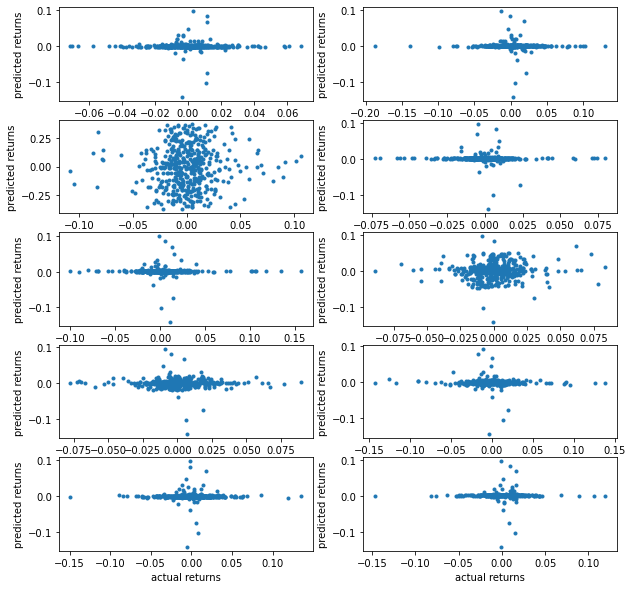

In [19]:
# actual test set one-day ahead returns v.s. predicted test set one-day ahead returns for each ticker
fig, ax = plt.subplots(5, 2)

ax_flatten = ax.flatten()

for i in range(len(tickers)):
    print(tickers[i])
    ax_flatten[i].plot(one_day_ahead_return_test.iloc[:,i], Y_pred_rolling[i], ".")
    ax_flatten[i].set_ylabel('predicted returns')
    ax_flatten[i].set_xlabel('actual returns')

BMY
CTLT
JAZZ
JNJ
LLY
MRK
PFE
PRGO
VTRS
ZTS


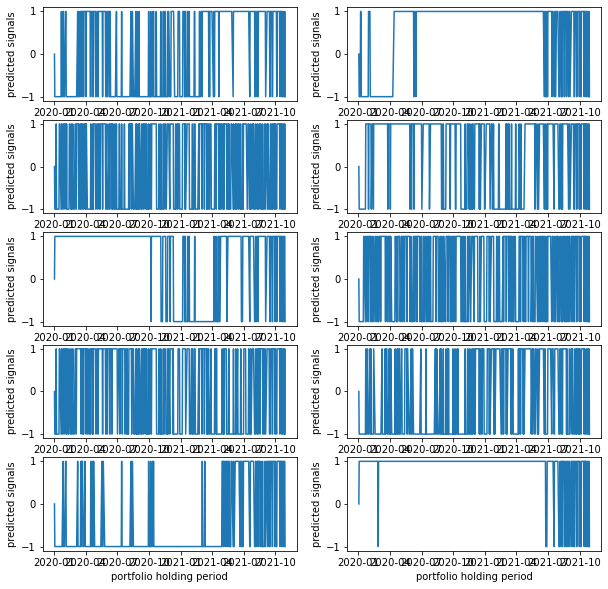

In [25]:
# trading signals of each ticker generated by Neural Network prediction from the rolling window size
fig, ax = plt.subplots(5, 2)

ax_flatten = ax.flatten()

for i in range(len(tickers)):
    print(tickers[i])
    signal = np.ones(len(Y_pred_rolling[i]))
    signal[np.where(np.array(Y_pred_rolling[i]) < 0)] = -1 # create the trading signals
    signal = np.insert(signal, 0, 0)
    ax_flatten[i].plot(portfolio_holding_period, signal)
    ax_flatten[i].set_ylabel('predicted signals')
    ax_flatten[i].set_xlabel('portfolio holding period')

In [21]:
# optimal position in each ticker
pd.DataFrame(np.array(pos_optimal_each_asset).T, columns = tickers, index = portfolio_holding_period)

,BMY,CTLT,JAZZ,JNJ,LLY,MRK,PFE,PRGO,VTRS,ZTS
Date,,,,,,,,,,
2020-01-02,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.00000,0.000000
2020-01-03,-1667.256352,-1766.7845,-673.718284,-716.736278,780.69793,-1206.008882,-2887.228115,-2016.140569,-4913.82152,753.892116
2020-01-06,-1667.256352,-1766.7845,-673.718284,-716.736278,780.69793,-1206.008882,-2887.228115,-2016.140569,-4913.82152,753.892116
2020-01-07,-1667.256352,1766.7845,673.718284,-716.736278,780.69793,-1206.008882,2887.228115,-2016.140569,-4913.82152,753.892116
2020-01-08,-1667.256352,1766.7845,-673.718284,-716.736278,780.69793,-1206.008882,-2887.228115,-2016.140569,-4913.82152,753.892116
...,...,...,...,...,...,...,...,...,...,...
2021-10-25,1667.256352,1766.7845,673.718284,716.736278,780.69793,1206.008882,2887.228115,2016.140569,4913.82152,753.892116
2021-10-26,-1667.256352,-1766.7845,-673.718284,-716.736278,-780.69793,-1206.008882,-2887.228115,-2016.140569,-4913.82152,-753.892116
2021-10-27,-1667.256352,-1766.7845,-673.718284,-716.736278,780.69793,-1206.008882,-2887.228115,-2016.140569,4913.82152,-753.892116


[*********************100%***********************]  1 of 1 completed


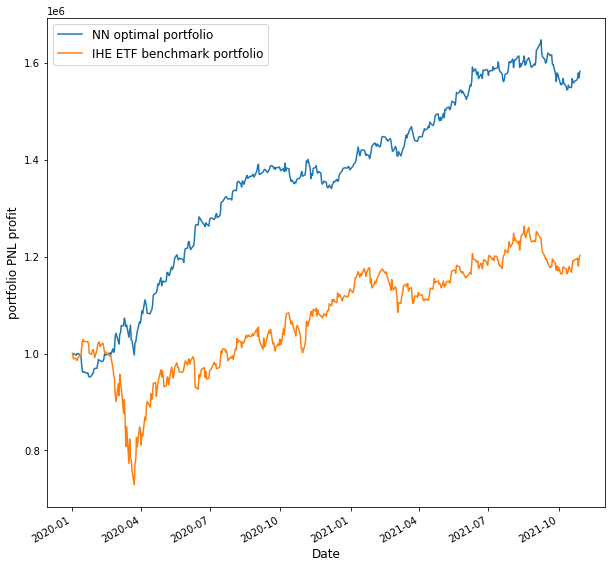

In [22]:
# entire portfolio PNL plot in out-of-sample period
portfolio_PNL = np.sum(PNL_optimal_each_asset,axis = 0)
plt.plot(portfolio_holding_period, portfolio_PNL)
plt.xlabel('portfolio holding period', size = 12)
plt.ylabel('portfolio PNL profit', size = 12)

# extract the stock price of the ETF IHE (iShares US Pharmaceuticals ETF) in out-of-sample period
start = pd.to_datetime('2020, 1, 1')
end = pd.to_datetime("today")
df = yf.download('IHE', start=start, end=end)
ETF_prices = df['Adj Close']
(1000000/ETF_prices[0]*ETF_prices).plot() # $1000000 is the inital capital
plt.legend(['NN optimal portfolio', 'IHE ETF benchmark portfolio'], fontsize = 12)

In [23]:
# portfolio returns given each asset calculated under optimal parameters
print('The return of the entire portfolio under optimal window sizes for each ticker is', (portfolio_PNL[-1] - portfolio_PNL[0])/ portfolio_PNL[0])

The return of the entire portfolio under optimal window sizes for each ticker is 0.5828361620679109


**Source Acknowledgement: https://www.bdfbook.com/#code**